# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.distributions import Categorical
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("archive/train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [28]:
# Over every single 
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [29]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_tr

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,CALL_TYPE_A,...,HR_21,HR_22,HR_23,DAY_TYPE_A,POLYLINE_SEGMENTS,YR,MON,DAY,HR,WK
0,3,1372636854620000520,-2.0,-66.0,20000520,1372636854,False,"[(41.151951, -8.574678), (41.151942, -8.574705...",0,0,...,0,0,0,1,2.866667,2013,7,1,0,0
1,4,1372637091620000337,-2.0,-66.0,20000337,1372637091,False,"[(41.18049, -8.645994), (41.180517, -8.645949)...",0,0,...,0,0,0,1,1.933333,2013,7,1,0,0
2,6,1372637210620000456,-2.0,-66.0,20000456,1372637210,False,"[(41.145948, -8.57952), (41.145039, -8.580942)...",0,0,...,0,0,0,1,2.400000,2013,7,1,0,0
3,7,1372637299620000011,-2.0,-66.0,20000011,1372637299,False,"[(41.146182, -8.617563), (41.145849, -8.617527...",0,0,...,0,0,0,1,2.266667,2013,7,1,0,0
4,8,1372637274620000403,-2.0,-66.0,20000403,1372637274,False,"[(41.140557, -8.611794), (41.140575, -8.611785...",0,0,...,0,0,0,1,2.533333,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862016,1710654,1404166892620000500,-1.0,15.0,20000500,1404166892,False,"[(41.148828, -8.585712), (41.148972, -8.586009...",0,0,...,0,1,0,1,2.666667,2014,6,30,22,0
862017,1710659,1403941536620000213,52688.0,-66.0,20000213,1403941536,False,"[(41.157099, -8.574732), (41.156775, -8.574849...",0,1,...,0,0,0,1,3.600000,2014,6,28,7,5
862018,1710661,1404164723620000332,-1.0,15.0,20000332,1404164723,False,"[(41.148567, -8.585703), (41.148855, -8.585739...",0,0,...,1,0,0,1,2.200000,2014,6,30,21,0
862019,1710665,1404171463620000698,-2.0,-66.0,20000698,1404171463,False,"[(41.14602, -8.612469), (41.145993, -8.612487)...",0,0,...,0,0,1,1,2.133333,2014,6,30,23,0


In [6]:
df_tr.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06,1.710670e+06,1.710670e+06,1.710670e+06,1.710670e+06,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09,7.164265e+02,2.013498e+03,6.586992e+00,1.559326e+01,1.192222e+01,3.054860e+00
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06,6.847512e+02,4.999963e-01,3.412274e+00,8.843357e+00,6.234564e+00,1.967392e+00
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09,4.050000e+02,2.013000e+03,4.000000e+00,8.000000e+00,7.000000e+00,1.000000e+00
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09,6.000000e+02,2.013000e+03,7.000000e+00,1.500000e+01,1.200000e+01,3.000000e+00
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09,8.700000e+02,2.014000e+03,1.000000e+01,2.300000e+01,1.700000e+01,5.000000e+00
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09,5.820000e+04,2.014000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00


### Create a Prediction File

In [7]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4264615618442 median=600.0 std=684.7511617510816


In [8]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("archive/sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

In [9]:
df_tr.columns

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE', 'LEN', 'YR', 'MON',
       'DAY', 'HR', 'WK'],
      dtype='object')

In [10]:
df_tr["LEN"].describe()

count    1.710670e+06
mean     7.164265e+02
std      6.847512e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.000000e+02
75%      8.700000e+02
max      5.820000e+04
Name: LEN, dtype: float64

In [11]:
df_tr["LEN"].quantile([0.25, 0.75]) #0.25: 405, 0.75: 870
df_LENiqr = df_tr[df_tr["LEN"].isin(list(range(405, 870, 15)))]
# df_LENiqr["LEN"].unique()

<AxesSubplot:ylabel='Frequency'>

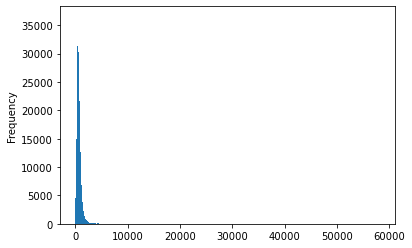

In [12]:
df_tr["LEN"].plot(kind='hist', bins=np.arange(df_tr['LEN'].min(), df_tr['LEN'].max(),15))


Extremely Right Skewed Data, will take a look at just the Inter Quartile Range next

<AxesSubplot:ylabel='Frequency'>

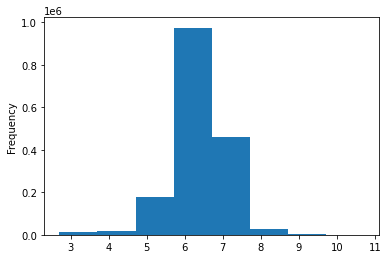

In [13]:
df_tr["logTransformLEN"] = df_tr[df_tr["LEN"] != 0]["LEN"].apply(np.log)#.plot(kind='hist', bins=np.arange(df_tr['LEN'].min(), df_tr['LEN'].max(),15))
df_tr["logTransformLEN"].plot(kind='hist', bins=np.arange(df_tr['logTransformLEN'].min(), df_tr['logTransformLEN'].max()))
# df_tr["logTransformLEN"].describe()

Log transformation makes the distribution more symmetric, need to check kurtosis and normality tests

<AxesSubplot:ylabel='Frequency'>

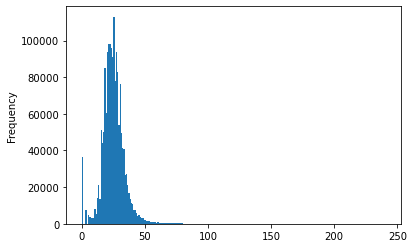

In [14]:
df_tr["sqrtTransformLEN"] = df_tr["LEN"].apply(np.sqrt)#.plot(kind='hist', bins=np.arange(df_tr['LEN'].min(), df_tr['LEN'].max(),15))
df_tr["sqrtTransformLEN"].plot(kind='hist', bins=np.arange(df_tr['sqrtTransformLEN'].min(), df_tr['sqrtTransformLEN'].max()))
# df_tr["logTransformLEN"].describe()
# np.arange(df_tr['sqrtTransformLEN'].min(), df_tr['sqrtTransformLEN'].max())

Square Root Transform didn't drastically change skewness; go with InterQuartile Range

Some origin stands are more active than others. Need to investigate wher ethey are to maybe take advantage of an inductive bias to inform our model.

(862024, 15) (1710670, 17)
(862024, 15) (862024, 15)


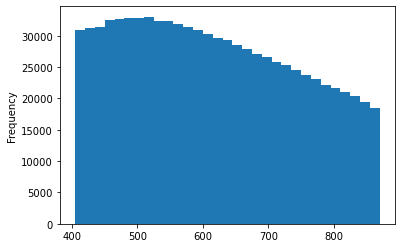

In [15]:
df_LENiqr["LEN"].plot(kind='hist', bins=np.arange(df_LENiqr['LEN'].min(), df_LENiqr['LEN'].max()+2*15,15))
# np.arange(df_LENiqr['LEN'].min(), df_LENiqr['LEN'].max()+1,15)
print(df_LENiqr.shape, df_tr.shape)
df_tr = df_LENiqr
print(df_LENiqr.shape, df_tr.shape)

average frequency: 6919.158730158731

2 most Frequently used Taxi Stands (Type B)


15.0    43766
57.0    24721
Name: ORIGIN_STAND, dtype: int64

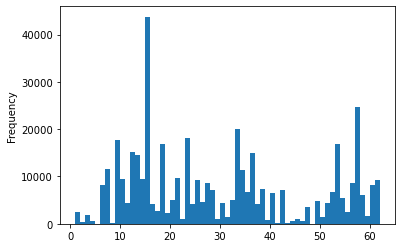

In [16]:
df_tr["ORIGIN_STAND"].plot(kind='hist', bins=np.arange(df_tr['ORIGIN_STAND'].min(), df_tr['ORIGIN_STAND'].max(),1))

avgFreq = df_tr["ORIGIN_STAND"].value_counts().mean()
print(f"average frequency: {avgFreq}\n")
kMostFreq = 2
print(f"{kMostFreq} most Frequently used Taxi Stands (Type B)")
df_tr["ORIGIN_STAND"].value_counts().head(kMostFreq)

In [17]:
df_tr["LEN"].describe()

count    862024.000000
mean        609.383091
std         129.492384
min         405.000000
25%         495.000000
50%         600.000000
75%         720.000000
max         855.000000
Name: LEN, dtype: float64

Using: 862024/862024


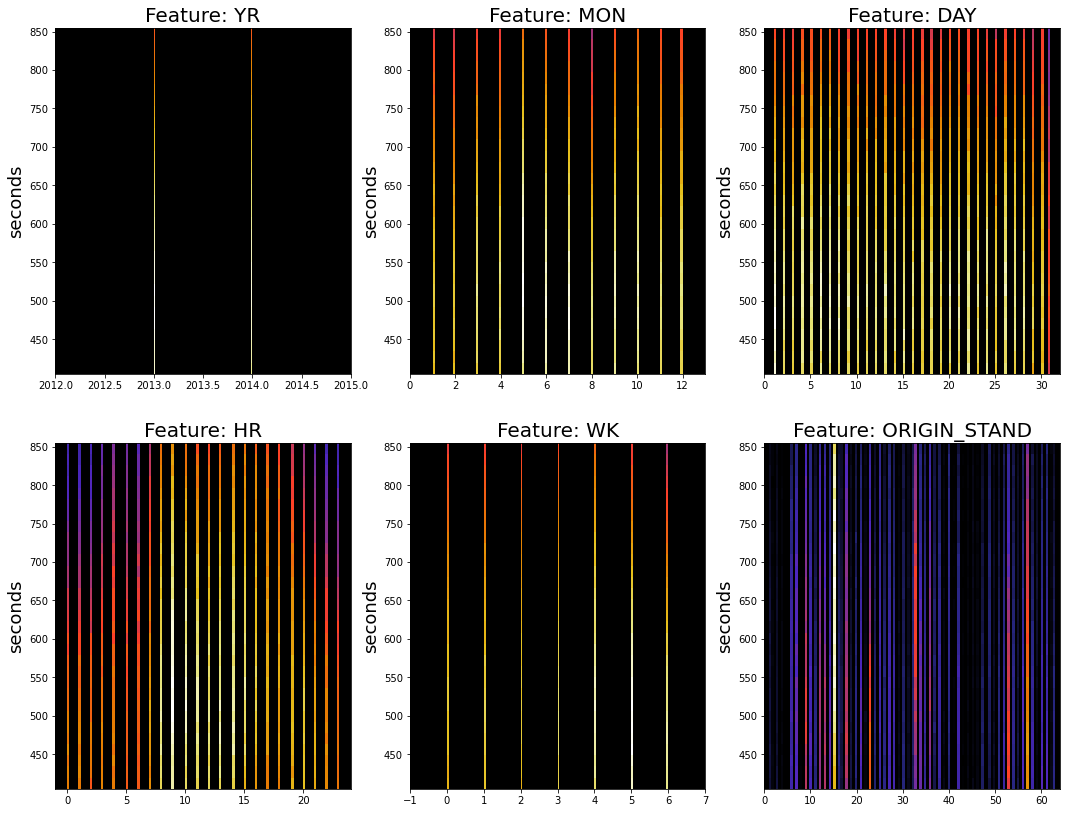

In [18]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3 #factor of sigma(std dev)

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = len(list(range(405, 870, 15))) #(int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


YR seems to not matter. Generally fewer long-time trips are taken for each value of a unit of time. May seems to be popular with a high volume of rides (being thicker than rest of the months), and seems to have more short-time trips, but generally differnet types of trips expereince more frequency. The middle hours in a day seem to be more popular, which is undertsnabdle as people usually take rides during daytiem after work or school. The weekends seem to have more freqeunt short-time trips. Differnet taxi stands have different frequencies, and some taxi stand between 10 and 20 has high amount of trips for all types of trip-durations, while others are not nearly as active.

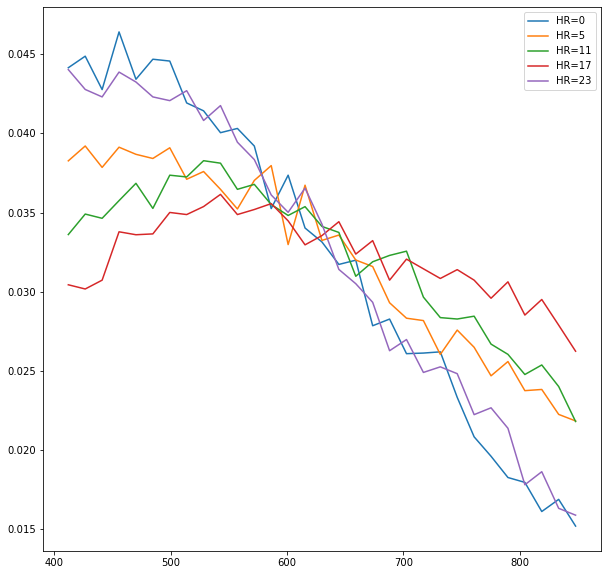

In [19]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.pairplot(df_tr)
# plt.show()

In [21]:
df_tr

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0
6,1372637210620000456,C,NaN,NaN,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,2013,7,1,0,0
7,1372637299620000011,C,NaN,NaN,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[...",495,2013,7,1,0,0
8,1372637274620000403,C,NaN,NaN,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,B,NaN,15.0,20000500,1404166892,A,False,"[[-8.585712,41.148828],[-8.586009,41.148972],[...",585,2014,6,30,22,0
1710659,1403941536620000213,A,52688.0,NaN,20000213,1403941536,A,False,"[[-8.574732,41.157099],[-8.574849,41.156775],[...",795,2014,6,28,7,5
1710661,1404164723620000332,B,NaN,15.0,20000332,1404164723,A,False,"[[-8.585703,41.148567],[-8.585739,41.148855],[...",480,2014,6,30,21,0
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0


In [22]:
df_tr.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK
count,8.620240e+05,188697.000000,435907.000000,8.620240e+05,8.620240e+05,862024.000000,862024.000000,862024.000000,862024.000000,862024.000000,862024.000000
mean,1.388574e+18,24700.477718,29.999759,2.000035e+07,1.388574e+09,609.383091,2013.497016,6.581379,15.581892,11.886340,3.088656
std,9.247692e+15,19584.955125,17.534991,2.104318e+02,9.247692e+06,129.492384,0.499991,3.385324,8.843991,6.300481,1.974413
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09,405.000000,2013.000000,1.000000,1.000000,0.000000,0.000000
25%,1.380557e+18,6728.000000,15.000000,2.000017e+07,1.380557e+09,495.000000,2013.000000,4.000000,8.000000,7.000000,1.000000
50%,1.388448e+18,18959.000000,27.000000,2.000034e+07,1.388448e+09,600.000000,2013.000000,7.000000,15.000000,12.000000,3.000000
75%,1.396840e+18,41014.000000,46.000000,2.000052e+07,1.396840e+09,720.000000,2014.000000,10.000000,23.000000,17.000000,5.000000
max,1.404172e+18,63882.000000,63.000000,2.000097e+07,1.404172e+09,855.000000,2014.000000,12.000000,31.000000,23.000000,6.000000


In [23]:
df_tr.isnull().sum() #could be B and C type rides, OK to keep - chnge to -1 and -2?
#make meaningful illegal values rather than NaN/null

TRIP_ID              0
CALL_TYPE            0
ORIGIN_CALL     673327
ORIGIN_STAND    426117
TAXI_ID              0
TIMESTAMP            0
DAY_TYPE             0
MISSING_DATA         0
POLYLINE             0
LEN                  0
YR                   0
MON                  0
DAY                  0
HR                   0
WK                   0
dtype: int64

In [24]:
set(df_tr[df_tr["ORIGIN_CALL"].isnull()]["CALL_TYPE"])
a = df_tr.shape[0]- len(df_tr[df_tr["ORIGIN_CALL"].isnull()]["CALL_TYPE"]) == len(df_tr[df_tr["CALL_TYPE"] == "A"]) # True : al B and C's are null-type
a

True

In [25]:
# https://sparkbyexamples.com/pandas/pandas-replace-values-based-on-condition/

# for call in list(set(df_tr[df_tr["ORIGIN_CALL"].isnull()]["CALL_TYPE"])):
list(set(df_tr[df_tr["ORIGIN_CALL"].isnull()]["CALL_TYPE"]))
df_meaningfulCALLTYPE = df_tr.copy(deep=True)


df_meaningfulCALLTYPE["ORIGIN_CALL"].mask(df_meaningfulCALLTYPE["CALL_TYPE"] == "B", -1, inplace=True)
df_meaningfulCALLTYPE["ORIGIN_CALL"].mask(df_meaningfulCALLTYPE["CALL_TYPE"] == "C", -2, inplace=True)

df_tr = df_meaningfulCALLTYPE
df_tr

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
3,1372636854620000520,C,-2.0,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,-2.0,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0
6,1372637210620000456,C,-2.0,NaN,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,2013,7,1,0,0
7,1372637299620000011,C,-2.0,NaN,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[...",495,2013,7,1,0,0
8,1372637274620000403,C,-2.0,NaN,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,B,-1.0,15.0,20000500,1404166892,A,False,"[[-8.585712,41.148828],[-8.586009,41.148972],[...",585,2014,6,30,22,0
1710659,1403941536620000213,A,52688.0,NaN,20000213,1403941536,A,False,"[[-8.574732,41.157099],[-8.574849,41.156775],[...",795,2014,6,28,7,5
1710661,1404164723620000332,B,-1.0,15.0,20000332,1404164723,A,False,"[[-8.585703,41.148567],[-8.585739,41.148855],[...",480,2014,6,30,21,0
1710665,1404171463620000698,C,-2.0,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0


In [26]:
# https://sparkbyexamples.com/pandas/pandas-replace-values-based-on-condition/

# for call in list(set(df_tr[df_tr["ORIGIN_CALL"].isnull()]["CALL_TYPE"])):

df_meaningfulORIGINCALL = df_tr.copy(deep=True)


df_meaningfulORIGINCALL["ORIGIN_STAND"].mask(df_meaningfulORIGINCALL["CALL_TYPE"].isin(["A","C"]) , -66, inplace=True)

df_tr = df_meaningfulORIGINCALL
df_tr

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
3,1372636854620000520,C,-2.0,-66.0,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,-2.0,-66.0,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0
6,1372637210620000456,C,-2.0,-66.0,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,2013,7,1,0,0
7,1372637299620000011,C,-2.0,-66.0,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[...",495,2013,7,1,0,0
8,1372637274620000403,C,-2.0,-66.0,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,B,-1.0,15.0,20000500,1404166892,A,False,"[[-8.585712,41.148828],[-8.586009,41.148972],[...",585,2014,6,30,22,0
1710659,1403941536620000213,A,52688.0,-66.0,20000213,1403941536,A,False,"[[-8.574732,41.157099],[-8.574849,41.156775],[...",795,2014,6,28,7,5
1710661,1404164723620000332,B,-1.0,15.0,20000332,1404164723,A,False,"[[-8.585703,41.148567],[-8.585739,41.148855],[...",480,2014,6,30,21,0
1710665,1404171463620000698,C,-2.0,-66.0,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0


In [27]:
print(df_tr.shape) #Find duplicates
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
print(any(list(df_tr.duplicated(keep=False)))) #duplicates are True

(862024, 15)
False


In [28]:
df_tr[df_tr.duplicated()] #How are these duplicates? Not dropping either one

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK


In [29]:
# print(set(list(df_tr["CALL_TYPE"])))
# print(set(list(df_tr["ORIGIN_STAND"])))

In [30]:
df_tr["MISSING_DATA"].value_counts() #points have missings Polyline data

False    862021
True          3
Name: MISSING_DATA, dtype: int64

In [31]:
df_goodPolyline = df_tr.drop(df_tr[df_tr['MISSING_DATA'] == True].index)

In [32]:
df_goodPolyline[df_goodPolyline["POLYLINE"] == "[]"] #check for empty polylines

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK


In [33]:
df_goodPolyline = df_goodPolyline.drop(df_goodPolyline[df_goodPolyline["POLYLINE"] == "[]"]["POLYLINE"].index)
df_goodPolyline

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
3,1372636854620000520,C,-2.0,-66.0,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,-2.0,-66.0,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0
6,1372637210620000456,C,-2.0,-66.0,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,2013,7,1,0,0
7,1372637299620000011,C,-2.0,-66.0,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[...",495,2013,7,1,0,0
8,1372637274620000403,C,-2.0,-66.0,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,B,-1.0,15.0,20000500,1404166892,A,False,"[[-8.585712,41.148828],[-8.586009,41.148972],[...",585,2014,6,30,22,0
1710659,1403941536620000213,A,52688.0,-66.0,20000213,1403941536,A,False,"[[-8.574732,41.157099],[-8.574849,41.156775],[...",795,2014,6,28,7,5
1710661,1404164723620000332,B,-1.0,15.0,20000332,1404164723,A,False,"[[-8.585703,41.148567],[-8.585739,41.148855],[...",480,2014,6,30,21,0
1710665,1404171463620000698,C,-2.0,-66.0,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0


In [34]:
df_cleaned = df_goodPolyline
df_cleaned

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
3,1372636854620000520,C,-2.0,-66.0,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,-2.0,-66.0,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0
6,1372637210620000456,C,-2.0,-66.0,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,2013,7,1,0,0
7,1372637299620000011,C,-2.0,-66.0,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[...",495,2013,7,1,0,0
8,1372637274620000403,C,-2.0,-66.0,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,B,-1.0,15.0,20000500,1404166892,A,False,"[[-8.585712,41.148828],[-8.586009,41.148972],[...",585,2014,6,30,22,0
1710659,1403941536620000213,A,52688.0,-66.0,20000213,1403941536,A,False,"[[-8.574732,41.157099],[-8.574849,41.156775],[...",795,2014,6,28,7,5
1710661,1404164723620000332,B,-1.0,15.0,20000332,1404164723,A,False,"[[-8.585703,41.148567],[-8.585739,41.148855],[...",480,2014,6,30,21,0
1710665,1404171463620000698,C,-2.0,-66.0,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0


In [35]:
#change represnetation of Call Type and Day Type to one-hot encoding
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [36]:
print(list(set(list(df_cleaned["CALL_TYPE"]))))
print(list(set(list(df_cleaned["DAY_TYPE"])))) # Kaggle only has 1 day type on test data, matches training

['B', 'A', 'C']
['A']


In [37]:
df_cleaned = pd.get_dummies(df_cleaned, columns=['CALL_TYPE'])
#creates 3 columns for each CALL_TYPE_X: X in {A, B, C} each either 1 and rest 0
df_tr = df_cleaned
df_tr

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
3,1372636854620000520,-2.0,-66.0,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0,0,0,1
4,1372637091620000337,-2.0,-66.0,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0,0,0,1
6,1372637210620000456,-2.0,-66.0,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,2013,7,1,0,0,0,0,1
7,1372637299620000011,-2.0,-66.0,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[...",495,2013,7,1,0,0,0,0,1
8,1372637274620000403,-2.0,-66.0,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,2013,7,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,-1.0,15.0,20000500,1404166892,A,False,"[[-8.585712,41.148828],[-8.586009,41.148972],[...",585,2014,6,30,22,0,0,1,0
1710659,1403941536620000213,52688.0,-66.0,20000213,1403941536,A,False,"[[-8.574732,41.157099],[-8.574849,41.156775],[...",795,2014,6,28,7,5,1,0,0
1710661,1404164723620000332,-1.0,15.0,20000332,1404164723,A,False,"[[-8.585703,41.148567],[-8.585739,41.148855],[...",480,2014,6,30,21,0,0,1,0
1710665,1404171463620000698,-2.0,-66.0,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0,0,0,1


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


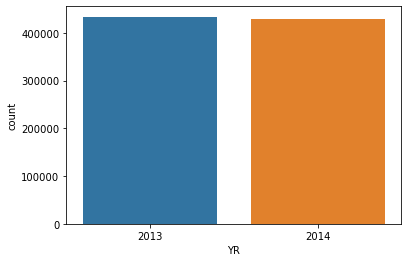

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


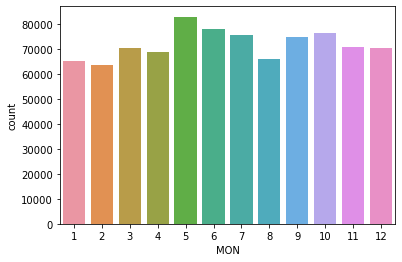

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


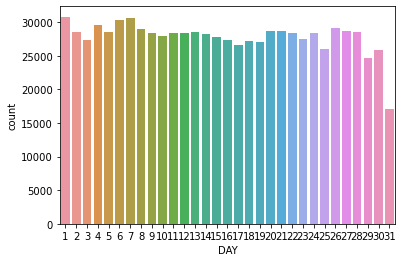

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


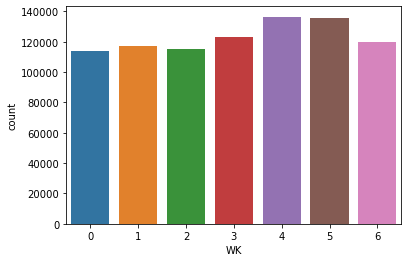

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


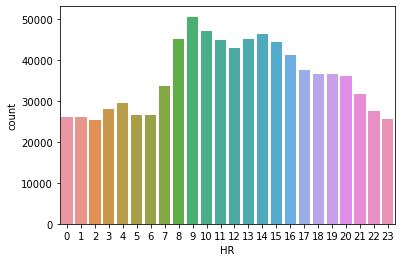

In [38]:
durations = ["YR", "MON", "DAY", "WK", "HR"]

sns.countplot(df_tr["YR"])
plt.show()
sns.countplot(df_tr["MON"]) #make the periodicity modelled by sinusoid?
plt.show()
sns.countplot(df_tr["DAY"])
plt.show()
sns.countplot(df_tr["WK"])
plt.show()
sns.countplot(df_tr["HR"])
plt.show()


# avgFreq = df_tr["ORIGIN_STAND"].value_counts().mean()
# print(f"average frequency: {avgFreq}\n")
# kMostFreq = 2
# print(f"{kMostFreq} most Frequently used Taxi Stands (Type B)")
# df_tr["ORIGIN_STAND"].value_counts().head(kMostFreq)

In [39]:
# df_tr#["CALL_TYPE"]

df_cleaned = pd.get_dummies(df_cleaned, columns=['YR'])
df_cleaned = pd.get_dummies(df_cleaned, columns=['MON'])
df_cleaned = pd.get_dummies(df_cleaned, columns=['DAY'])
df_cleaned = pd.get_dummies(df_cleaned, columns=['WK'])
df_cleaned = pd.get_dummies(df_cleaned, columns=['HR'])
df_tr = df_cleaned

In [40]:
df_tr = pd.get_dummies(df_tr, columns=['DAY_TYPE'])

In [41]:
df_tr
#created 1 column for single DAY_TYPE_A
#All data from a normal day or weekend; no special/holidays or day before those days

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,CALL_TYPE_A,CALL_TYPE_B,...,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,DAY_TYPE_A
3,1372636854620000520,-2.0,-66.0,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1372637091620000337,-2.0,-66.0,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1372637210620000456,-2.0,-66.0,20000456,1372637210,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,0,0,...,0,0,0,0,0,0,0,0,0,1
7,1372637299620000011,-2.0,-66.0,20000011,1372637299,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[...",495,0,0,...,0,0,0,0,0,0,0,0,0,1
8,1372637274620000403,-2.0,-66.0,20000403,1372637274,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,-1.0,15.0,20000500,1404166892,False,"[[-8.585712,41.148828],[-8.586009,41.148972],[...",585,0,1,...,0,0,0,0,0,0,0,1,0,1
1710659,1403941536620000213,52688.0,-66.0,20000213,1403941536,False,"[[-8.574732,41.157099],[-8.574849,41.156775],[...",795,1,0,...,0,0,0,0,0,0,0,0,0,1
1710661,1404164723620000332,-1.0,15.0,20000332,1404164723,False,"[[-8.585703,41.148567],[-8.585739,41.148855],[...",480,0,1,...,0,0,0,0,0,0,1,0,0,1
1710665,1404171463620000698,-2.0,-66.0,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,0,0,...,0,0,0,0,0,0,0,0,1,1


In [42]:
print((list(df_tr.index))[:len(list(df_tr.index))//2][0],(list(df_tr.index))[:len(list(df_tr.index))//2][-1])
print((list(df_tr.index))[len(list(df_tr.index))//2 :][0],(list(df_tr.index))[len(list(df_tr.index))//2 :][-1])
# (list(df_tr.index))[len(list(df_tr.index))//2 - 1

3 853563
853572 1710666


In [43]:
#TODO: convert polylien from string to numpy matrixes and switc long,lat to lat long fo each row in the series

# https://stackoverflow.com/questions/1926741/how-do-i-parse-a-string-representing-a-nested-list-into-an-actual-list
import ast

df_fixpolylines = df_tr.copy(deep = True)

# df_tr["POLYLINE"][0].apply(ast.literal_eval)
lats = []
longs = []

polylines = []


for i in tqdm(df_tr.loc[(list(df_tr.index))[:len(list(df_tr.index))//2]]["POLYLINE"]):#df_tr.shape[0])): #862021)):#
    v = ast.literal_eval(i)
#     print(f"v: {v}")
    
    newpolyline = []
    for e in v:
#         print(f"long, lat: {e}")
        long, lat = e
        e = lat, long
        lats.append(lat)
        longs.append(long)
#         print(f"lat, long: {e}\n")
        newpolyline.append(e)
    polylines.append(newpolyline)
#     print(f"polylines: {polylines}\n\n")



for i in tqdm(df_tr.loc[(list(df_tr.index))[len(list(df_tr.index))//2 : ]]["POLYLINE"]):#df_tr.shape[0])): #862021)):#
    v = ast.literal_eval(i)
#     print(f"v: {v}")
    
    newpolyline = []
    for e in v:
#         print(f"long, lat: {e}")
        long, lat = e
        e = lat, long
        lats.append(lat)
        longs.append(long)
#         print(f"lat, long: {e}\n")
        newpolyline.append(e)
    polylines.append(newpolyline)
    
#?
# map_df["lat"] = lats
# map_df["long"] = longs

df_fixpolylines["POLYLINE"] = pd.Series(polylines)
#TODO might have to parallelize

100%|██████████| 431011/431011 [02:19<00:00, 3094.59it/s]


In [44]:
print(len(df_fixpolylines["POLYLINE"]))
tofix = df_fixpolylines[df_fixpolylines["POLYLINE"].isnull() == True].index
print(len(tofix))
print(len(df_fixpolylines["POLYLINE"]) - len(tofix))
cutpolyline = len(df_fixpolylines["POLYLINE"]) - len(tofix)
print(cutpolyline)

862021
426827
435194
435194


In [45]:
tofix = df_fixpolylines[df_fixpolylines["POLYLINE"].isnull() == True].index
tofix

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def strictly_increasing(L):
    return all(x<y for x, y in zip(L, L[1:]))
print(tofix)
print(strictly_increasing(tofix))

Int64Index([ 862023,  862024,  862026,  862028,  862031,  862032,  862033,
             862034,  862036,  862037,
            ...
            1710646, 1710647, 1710649, 1710650, 1710651, 1710654, 1710659,
            1710661, 1710665, 1710666],
           dtype='int64', length=426827)
True


In [46]:
print(len(tofix))
print(cutpolyline)
polylines = polylines[:cutpolyline]
print(len(polylines))
print(len(polylines) + len(tofix) == df_fixpolylines.shape[0])

426827
435194
435194
True


In [47]:
print(len(tofix) + cutpolyline, df_fixpolylines.shape[0])

862021 862021


In [48]:
for i in tqdm(df_tr.loc[tofix]["POLYLINE"]):#df_tr.shape[0])): #862021)):#
    v = ast.literal_eval(i)
#     print(f"v: {v}")
    
    newpolyline = []
    for e in v:
#         print(f"long, lat: {e}")
        long, lat = e
        e = lat, long
        lats.append(lat)
        longs.append(long)
#         print(f"lat, long: {e}\n")
        newpolyline.append(e)
    polylines.append(newpolyline)

100%|██████████| 426827/426827 [02:20<00:00, 3035.15it/s]


In [49]:
len(polylines)

862021

In [50]:
df_fixpolylines["POLYLINE"] = polylines
df_fixpolylines["LEN"] = df_fixpolylines["POLYLINE"].apply(len)
print(df_fixpolylines["LEN"] == df_tr["LEN"]/15  + 1)

3          True
4          True
6          True
7          True
8          True
           ... 
1710654    True
1710659    True
1710661    True
1710665    True
1710666    True
Name: LEN, Length: 862021, dtype: bool


In [51]:
df_fixpolylines[df_fixpolylines.notnull() == True].shape == df_fixpolylines[df_fixpolylines.notnull() == True].shape

True

In [52]:
df_tr = df_fixpolylines
df_tr

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,CALL_TYPE_A,CALL_TYPE_B,...,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,DAY_TYPE_A
3,1372636854620000520,-2.0,-66.0,20000520,1372636854,False,"[(41.151951, -8.574678), (41.151942, -8.574705...",43,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1372637091620000337,-2.0,-66.0,20000337,1372637091,False,"[(41.18049, -8.645994), (41.180517, -8.645949)...",29,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1372637210620000456,-2.0,-66.0,20000456,1372637210,False,"[(41.145948, -8.57952), (41.145039, -8.580942)...",36,0,0,...,0,0,0,0,0,0,0,0,0,1
7,1372637299620000011,-2.0,-66.0,20000011,1372637299,False,"[(41.146182, -8.617563), (41.145849, -8.617527...",34,0,0,...,0,0,0,0,0,0,0,0,0,1
8,1372637274620000403,-2.0,-66.0,20000403,1372637274,False,"[(41.140557, -8.611794), (41.140575, -8.611785...",38,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,-1.0,15.0,20000500,1404166892,False,"[(41.148828, -8.585712), (41.148972, -8.586009...",40,0,1,...,0,0,0,0,0,0,0,1,0,1
1710659,1403941536620000213,52688.0,-66.0,20000213,1403941536,False,"[(41.157099, -8.574732), (41.156775, -8.574849...",54,1,0,...,0,0,0,0,0,0,0,0,0,1
1710661,1404164723620000332,-1.0,15.0,20000332,1404164723,False,"[(41.148567, -8.585703), (41.148855, -8.585739...",33,0,1,...,0,0,0,0,0,0,1,0,0,1
1710665,1404171463620000698,-2.0,-66.0,20000698,1404171463,False,"[(41.14602, -8.612469), (41.145993, -8.612487)...",32,0,0,...,0,0,0,0,0,0,0,0,1,1


In [53]:
# https://stackoverflow.com/questions/72583423/combine-multiple-rows-of-lists-into-one-big-list-using-pandas
coords = df_tr["POLYLINE"].explode().to_list()
coords = np.array([list(i) for i in coords])
coords

array([[41.151951, -8.574678],
       [41.151942, -8.574705],
       [41.151933, -8.574696],
       ...,
       [41.158764, -8.627436],
       [41.158746, -8.627427],
       [41.158755, -8.627454]])

In [54]:
# https://www.julienphalip.com/blog/drawing-geographical-density-maps-with-matplotlib/

import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/61346989/no-module-named-code-x-code-is-not-a-package-python
# from code.data import load_data#
%matplotlib inline

def density_map(latitudes, longitudes, center, bins=1000, radius=0.1):  
    cmap = copy.copy(plt.cm.jet)
    cmap.set_bad((0,0,0))  # Fill background with black

    # Center the map around the provided center coordinates
    histogram_range = [
        [center[1] - radius, center[1] + radius],
        [center[0] - radius, center[0] + radius]
    ]
    
    fig = plt.figure(figsize=(5,5))
    plt.hist2d(longitudes, latitudes, bins=bins, norm=LogNorm(),
               cmap=cmap, range=histogram_range)

    # Remove all axes and annotations to keep the map clean and simple
    plt.grid('off')
    plt.axis('off')
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

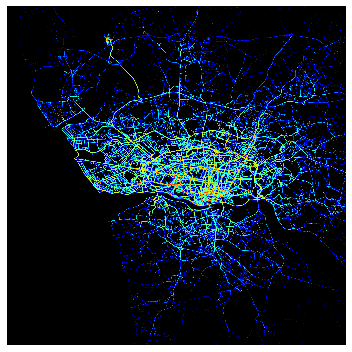

In [55]:
# https://www.julienphalip.com/blog/drawing-geographical-density-maps-with-matplotlib/
# Coordinates of Porto's city center
porto = [41.1579, -8.6291]
# Separate the latitude and longitude values from our list of coordinates
latitudes = coords[:,0]
longitudes = coords[:,1]
# Render the map
density_map(latitudes, longitudes, center=porto)

In [56]:
df_tr["POLYLINE_SEGMENTS"] = [i/15 for i in df_tr["LEN"]]
df_tr

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,CALL_TYPE_A,CALL_TYPE_B,...,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,DAY_TYPE_A,POLYLINE_SEGMENTS
3,1372636854620000520,-2.0,-66.0,20000520,1372636854,False,"[(41.151951, -8.574678), (41.151942, -8.574705...",43,0,0,...,0,0,0,0,0,0,0,0,1,2.866667
4,1372637091620000337,-2.0,-66.0,20000337,1372637091,False,"[(41.18049, -8.645994), (41.180517, -8.645949)...",29,0,0,...,0,0,0,0,0,0,0,0,1,1.933333
6,1372637210620000456,-2.0,-66.0,20000456,1372637210,False,"[(41.145948, -8.57952), (41.145039, -8.580942)...",36,0,0,...,0,0,0,0,0,0,0,0,1,2.400000
7,1372637299620000011,-2.0,-66.0,20000011,1372637299,False,"[(41.146182, -8.617563), (41.145849, -8.617527...",34,0,0,...,0,0,0,0,0,0,0,0,1,2.266667
8,1372637274620000403,-2.0,-66.0,20000403,1372637274,False,"[(41.140557, -8.611794), (41.140575, -8.611785...",38,0,0,...,0,0,0,0,0,0,0,0,1,2.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710654,1404166892620000500,-1.0,15.0,20000500,1404166892,False,"[(41.148828, -8.585712), (41.148972, -8.586009...",40,0,1,...,0,0,0,0,0,0,1,0,1,2.666667
1710659,1403941536620000213,52688.0,-66.0,20000213,1403941536,False,"[(41.157099, -8.574732), (41.156775, -8.574849...",54,1,0,...,0,0,0,0,0,0,0,0,1,3.600000
1710661,1404164723620000332,-1.0,15.0,20000332,1404164723,False,"[(41.148567, -8.585703), (41.148855, -8.585739...",33,0,1,...,0,0,0,0,0,1,0,0,1,2.200000
1710665,1404171463620000698,-2.0,-66.0,20000698,1404171463,False,"[(41.14602, -8.612469), (41.145993, -8.612487)...",32,0,0,...,0,0,0,0,0,0,0,1,1,2.133333


In [57]:
df_tr.to_csv("archive/clean.csv", sep = '\t')

# Load Cleaned Data and Public Test from CSV

In [30]:
# https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data
df_tr = pd.read_csv("archive/clean.csv", sep = '\t')

In [31]:
polylen = df_tr["LEN"]

In [32]:
df_test = pd.read_csv("archive/test_public.csv")
df_test

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [33]:
df_tr.columns

Index(['Unnamed: 0', 'TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', 'CALL_TYPE_A',
       'CALL_TYPE_B', 'CALL_TYPE_C', 'YR_2013', 'YR_2014', 'MON_1', 'MON_2',
       'MON_3', 'MON_4', 'MON_5', 'MON_6', 'MON_7', 'MON_8', 'MON_9', 'MON_10',
       'MON_11', 'MON_12', 'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5',
       'DAY_6', 'DAY_7', 'DAY_8', 'DAY_9', 'DAY_10', 'DAY_11', 'DAY_12',
       'DAY_13', 'DAY_14', 'DAY_15', 'DAY_16', 'DAY_17', 'DAY_18', 'DAY_19',
       'DAY_20', 'DAY_21', 'DAY_22', 'DAY_23', 'DAY_24', 'DAY_25', 'DAY_26',
       'DAY_27', 'DAY_28', 'DAY_29', 'DAY_30', 'DAY_31', 'WK_0', 'WK_1',
       'WK_2', 'WK_3', 'WK_4', 'WK_5', 'WK_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19',
       'HR_20', 'HR_21', 'HR_22', 'HR_23', 'DAY_TYPE_A', 'POLYLINE_SEGMENTS'],
      dtype='obje

## Clean/Format Public Test Data

In [34]:
df_test = pd.read_csv("archive/test_public.csv")
df_test

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [35]:
# polylen = df_tr["LEN"]

In [36]:
df_test["ORIGIN_CALL"].mask(df_test["CALL_TYPE"] == "B", -1, inplace=True)
df_test["ORIGIN_CALL"].mask(df_test["CALL_TYPE"] == "C", -2, inplace=True)

df_test = df_test
df_test

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,-1.0,15.0,20000542,1408039037,A,False
1,T2,B,-1.0,57.0,20000108,1408038611,A,False
2,T3,B,-1.0,15.0,20000370,1408038568,A,False
3,T4,B,-1.0,53.0,20000492,1408039090,A,False
4,T5,B,-1.0,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,-1.0,53.0,20000020,1419170802,A,False
317,T325,C,-2.0,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [37]:
print(list(set(list(df_test["CALL_TYPE"]))))
print(list(set(list(df_test["DAY_TYPE"])))) # Kaggle only has 1 day type on test data, matches training

df_test = pd.get_dummies(df_test, columns=['CALL_TYPE'])
#creates 3 columns for each CALL_TYPE_X: X in {A, B, C} each either 1 and rest 0
df_test

['B', 'C', 'A']
['A']


,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,T1,-1.0,15.0,20000542,1408039037,A,False,0,1,0
1,T2,-1.0,57.0,20000108,1408038611,A,False,0,1,0
2,T3,-1.0,15.0,20000370,1408038568,A,False,0,1,0
3,T4,-1.0,53.0,20000492,1408039090,A,False,0,1,0
4,T5,-1.0,18.0,20000621,1408039177,A,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,NaN,20000430,1419171485,A,False,1,0,0
316,T324,-1.0,53.0,20000020,1419170802,A,False,0,1,0
317,T325,-2.0,NaN,20000207,1419172121,A,False,0,0,1
318,T326,76232.0,NaN,20000667,1419171980,A,False,1,0,0


In [38]:
df_test[["YR", "MON", "DAY", "HR", "WK"]] = df_test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_test

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR,MON,DAY,HR,WK
0,T1,-1.0,15.0,20000542,1408039037,A,False,0,1,0,2014,8,14,17,3
1,T2,-1.0,57.0,20000108,1408038611,A,False,0,1,0,2014,8,14,17,3
2,T3,-1.0,15.0,20000370,1408038568,A,False,0,1,0,2014,8,14,17,3
3,T4,-1.0,53.0,20000492,1408039090,A,False,0,1,0,2014,8,14,17,3
4,T5,-1.0,18.0,20000621,1408039177,A,False,0,1,0,2014,8,14,17,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,NaN,20000430,1419171485,A,False,1,0,0,2014,12,21,14,6
316,T324,-1.0,53.0,20000020,1419170802,A,False,0,1,0,2014,12,21,14,6
317,T325,-2.0,NaN,20000207,1419172121,A,False,0,0,1,2014,12,21,14,6
318,T326,76232.0,NaN,20000667,1419171980,A,False,1,0,0,2014,12,21,14,6


In [39]:
day = df_test["DAY"]
mon = df_test["MON"]
wk = df_test["WK"]
df_test

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR,MON,DAY,HR,WK
0,T1,-1.0,15.0,20000542,1408039037,A,False,0,1,0,2014,8,14,17,3
1,T2,-1.0,57.0,20000108,1408038611,A,False,0,1,0,2014,8,14,17,3
2,T3,-1.0,15.0,20000370,1408038568,A,False,0,1,0,2014,8,14,17,3
3,T4,-1.0,53.0,20000492,1408039090,A,False,0,1,0,2014,8,14,17,3
4,T5,-1.0,18.0,20000621,1408039177,A,False,0,1,0,2014,8,14,17,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,NaN,20000430,1419171485,A,False,1,0,0,2014,12,21,14,6
316,T324,-1.0,53.0,20000020,1419170802,A,False,0,1,0,2014,12,21,14,6
317,T325,-2.0,NaN,20000207,1419172121,A,False,0,0,1,2014,12,21,14,6
318,T326,76232.0,NaN,20000667,1419171980,A,False,1,0,0,2014,12,21,14,6


In [40]:
df_test = pd.get_dummies(df_test, columns=['YR'])
df_test = pd.get_dummies(df_test, columns=['MON'])
df_test = pd.get_dummies(df_test, columns=['DAY'])
df_test = pd.get_dummies(df_test, columns=['WK'])
df_test = pd.get_dummies(df_test, columns=['HR'])
df_test = pd.get_dummies(df_test, columns=['DAY_TYPE'])
df_test = df_test

# df_test["DAY"] = day
# df_test["MON"] = mon
# df_test["WK"] = wk
df_test



,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,...,HR_7,HR_8,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,DAY_TYPE_A
0,T1,-1.0,15.0,20000542,1408039037,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
1,T2,-1.0,57.0,20000108,1408038611,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
2,T3,-1.0,15.0,20000370,1408038568,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
3,T4,-1.0,53.0,20000492,1408039090,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
4,T5,-1.0,18.0,20000621,1408039177,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,NaN,20000430,1419171485,False,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
316,T324,-1.0,53.0,20000020,1419170802,False,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
317,T325,-2.0,NaN,20000207,1419172121,False,0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
318,T326,76232.0,NaN,20000667,1419171980,False,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [41]:
df_tr["ORIGIN_STAND"].mask(df_tr["CALL_TYPE_A"] == 1 , -66, inplace=True)
df_tr["ORIGIN_STAND"].mask(df_tr["CALL_TYPE_C"] == 1, -66, inplace=True)

In [42]:
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_tr

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,CALL_TYPE_A,...,HR_21,HR_22,HR_23,DAY_TYPE_A,POLYLINE_SEGMENTS,YR,MON,DAY,HR,WK
0,3,1372636854620000520,-2.0,-66.0,20000520,1372636854,False,"[(41.151951, -8.574678), (41.151942, -8.574705...",43,0,...,0,0,0,1,2.866667,2013,7,1,0,0
1,4,1372637091620000337,-2.0,-66.0,20000337,1372637091,False,"[(41.18049, -8.645994), (41.180517, -8.645949)...",29,0,...,0,0,0,1,1.933333,2013,7,1,0,0
2,6,1372637210620000456,-2.0,-66.0,20000456,1372637210,False,"[(41.145948, -8.57952), (41.145039, -8.580942)...",36,0,...,0,0,0,1,2.400000,2013,7,1,0,0
3,7,1372637299620000011,-2.0,-66.0,20000011,1372637299,False,"[(41.146182, -8.617563), (41.145849, -8.617527...",34,0,...,0,0,0,1,2.266667,2013,7,1,0,0
4,8,1372637274620000403,-2.0,-66.0,20000403,1372637274,False,"[(41.140557, -8.611794), (41.140575, -8.611785...",38,0,...,0,0,0,1,2.533333,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862016,1710654,1404166892620000500,-1.0,15.0,20000500,1404166892,False,"[(41.148828, -8.585712), (41.148972, -8.586009...",40,0,...,0,1,0,1,2.666667,2014,6,30,22,0
862017,1710659,1403941536620000213,52688.0,-66.0,20000213,1403941536,False,"[(41.157099, -8.574732), (41.156775, -8.574849...",54,1,...,0,0,0,1,3.600000,2014,6,28,7,5
862018,1710661,1404164723620000332,-1.0,15.0,20000332,1404164723,False,"[(41.148567, -8.585703), (41.148855, -8.585739...",33,0,...,1,0,0,1,2.200000,2014,6,30,21,0
862019,1710665,1404171463620000698,-2.0,-66.0,20000698,1404171463,False,"[(41.14602, -8.612469), (41.145993, -8.612487)...",32,0,...,0,0,1,1,2.133333,2014,6,30,23,0


In [43]:
# # Over every single 
# def polyline_to_trip_duration(polyline):
#     return max(polyline.count("[") - 2, 0) * 15

# # This code creates a new column, "LEN", in our dataframe. The value is
# # the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
# df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [44]:
# polylen = df_tr["LEN"]
# polylen
polylen = df_tr["LEN"]
polylen

0         43
1         29
2         36
3         34
4         38
          ..
862016    40
862017    54
862018    33
862019    32
862020    30
Name: LEN, Length: 862021, dtype: int64

In [45]:
df_tr.columns

Index(['Unnamed: 0', 'TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', 'CALL_TYPE_A',
       'CALL_TYPE_B', 'CALL_TYPE_C', 'YR_2013', 'YR_2014', 'MON_1', 'MON_2',
       'MON_3', 'MON_4', 'MON_5', 'MON_6', 'MON_7', 'MON_8', 'MON_9', 'MON_10',
       'MON_11', 'MON_12', 'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5',
       'DAY_6', 'DAY_7', 'DAY_8', 'DAY_9', 'DAY_10', 'DAY_11', 'DAY_12',
       'DAY_13', 'DAY_14', 'DAY_15', 'DAY_16', 'DAY_17', 'DAY_18', 'DAY_19',
       'DAY_20', 'DAY_21', 'DAY_22', 'DAY_23', 'DAY_24', 'DAY_25', 'DAY_26',
       'DAY_27', 'DAY_28', 'DAY_29', 'DAY_30', 'DAY_31', 'WK_0', 'WK_1',
       'WK_2', 'WK_3', 'WK_4', 'WK_5', 'WK_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19',
       'HR_20', 'HR_21', 'HR_22', 'HR_23', 'DAY_TYPE_A', 'POLYLINE_SEGMENTS',
       'YR', 'MON'

In [46]:
a = df_test.apply(lambda col: col.unique())
uniqdf = pd.DataFrame()

In [47]:
train_extra_features = list(set(df_tr).difference(set(df_test)))
# train_extra_features.append("DAY")
# train_extra_features.append("MON")
# train_extra_features.append("WK")
train_extra_features.sort()
train_extra_features

['DAY',
 'DAY_10',
 'DAY_11',
 'DAY_12',
 'DAY_13',
 'DAY_15',
 'DAY_16',
 'DAY_17',
 'DAY_18',
 'DAY_19',
 'DAY_2',
 'DAY_20',
 'DAY_22',
 'DAY_23',
 'DAY_24',
 'DAY_25',
 'DAY_26',
 'DAY_27',
 'DAY_28',
 'DAY_29',
 'DAY_3',
 'DAY_31',
 'DAY_4',
 'DAY_5',
 'DAY_7',
 'DAY_8',
 'DAY_9',
 'HR',
 'HR_0',
 'HR_1',
 'HR_10',
 'HR_18',
 'HR_19',
 'HR_20',
 'HR_21',
 'HR_22',
 'HR_23',
 'HR_4',
 'HR_5',
 'HR_9',
 'LEN',
 'MON',
 'MON_1',
 'MON_2',
 'MON_3',
 'MON_4',
 'MON_5',
 'MON_6',
 'MON_7',
 'POLYLINE',
 'POLYLINE_SEGMENTS',
 'Unnamed: 0',
 'WK',
 'WK_2',
 'WK_4',
 'YR',
 'YR_2013']

In [48]:
extraTrainFeatures = list(set(df_tr.columns).difference(set(df_test.columns)))
# train_extra_features.append("DAY")
# train_extra_features.append("MON")
# train_extra_features.append("WK")
extraTrainFeatures = list(set(extraTrainFeatures).difference({"POLYLINE"}))
extraTrainFeatures.sort()
extraTrainFeatures

['DAY',
 'DAY_10',
 'DAY_11',
 'DAY_12',
 'DAY_13',
 'DAY_15',
 'DAY_16',
 'DAY_17',
 'DAY_18',
 'DAY_19',
 'DAY_2',
 'DAY_20',
 'DAY_22',
 'DAY_23',
 'DAY_24',
 'DAY_25',
 'DAY_26',
 'DAY_27',
 'DAY_28',
 'DAY_29',
 'DAY_3',
 'DAY_31',
 'DAY_4',
 'DAY_5',
 'DAY_7',
 'DAY_8',
 'DAY_9',
 'HR',
 'HR_0',
 'HR_1',
 'HR_10',
 'HR_18',
 'HR_19',
 'HR_20',
 'HR_21',
 'HR_22',
 'HR_23',
 'HR_4',
 'HR_5',
 'HR_9',
 'LEN',
 'MON',
 'MON_1',
 'MON_2',
 'MON_3',
 'MON_4',
 'MON_5',
 'MON_6',
 'MON_7',
 'POLYLINE_SEGMENTS',
 'Unnamed: 0',
 'WK',
 'WK_2',
 'WK_4',
 'YR',
 'YR_2013']

In [49]:
df_tr = df_tr.drop(extraTrainFeatures,axis=1)
list(df_tr.columns) == list(df_test.columns)
df_tr

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,...,HR_7,HR_8,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,DAY_TYPE_A
0,1372636854620000520,-2.0,-66.0,20000520,1372636854,False,"[(41.151951, -8.574678), (41.151942, -8.574705...",0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1372637091620000337,-2.0,-66.0,20000337,1372637091,False,"[(41.18049, -8.645994), (41.180517, -8.645949)...",0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1372637210620000456,-2.0,-66.0,20000456,1372637210,False,"[(41.145948, -8.57952), (41.145039, -8.580942)...",0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1372637299620000011,-2.0,-66.0,20000011,1372637299,False,"[(41.146182, -8.617563), (41.145849, -8.617527...",0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1372637274620000403,-2.0,-66.0,20000403,1372637274,False,"[(41.140557, -8.611794), (41.140575, -8.611785...",0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862016,1404166892620000500,-1.0,15.0,20000500,1404166892,False,"[(41.148828, -8.585712), (41.148972, -8.586009...",0,1,0,...,0,0,0,0,0,0,0,0,0,1
862017,1403941536620000213,52688.0,-66.0,20000213,1403941536,False,"[(41.157099, -8.574732), (41.156775, -8.574849...",1,0,0,...,1,0,0,0,0,0,0,0,0,1
862018,1404164723620000332,-1.0,15.0,20000332,1404164723,False,"[(41.148567, -8.585703), (41.148855, -8.585739...",0,1,0,...,0,0,0,0,0,0,0,0,0,1
862019,1404171463620000698,-2.0,-66.0,20000698,1404171463,False,"[(41.14602, -8.612469), (41.145993, -8.612487)...",0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [50]:
# a.index #TODO invert data frome; remove rows in d_tr by axi id, origincall/stand
a

TRIP_ID         [T1, T2, T3, T4, T5, T6, T7, T8, T9, T10, T11,...
ORIGIN_CALL     [-1.0, 42612.0, 31780.0, -2.0, 85698.0, 37007....
ORIGIN_STAND    [15.0, 57.0, 53.0, 18.0, nan, 9.0, 56.0, 12.0,...
TAXI_ID         [20000542, 20000108, 20000370, 20000492, 20000...
TIMESTAMP       [1408039037, 1408038611, 1408038568, 140803909...
MISSING_DATA                                              [False]
CALL_TYPE_A                                                [0, 1]
CALL_TYPE_B                                                [1, 0]
CALL_TYPE_C                                                [0, 1]
YR_2014                                                       [1]
MON_8                                                      [1, 0]
MON_9                                                      [0, 1]
MON_10                                                     [0, 1]
MON_11                                                     [0, 1]
MON_12                                                     [0, 1]
DAY_1     

In [51]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_tr


# # Over every single 
# def polyline_to_trip_duration(polyline):
#     return max(polyline.count("[") - 2, 0) * 15

# # This code creates a new column, "LEN", in our dataframe. The value is
# # the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
# df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
df_tr["LEN"] = polylen

print(df_tr["LEN"])
D = df_tr.copy(deep=True)
D

0         43
1         29
2         36
3         34
4         38
          ..
862016    40
862017    54
862018    33
862019    32
862020    30
Name: LEN, Length: 862021, dtype: int64


,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
0,1372636854620000520,-2.0,-66.0,20000520,1372636854,False,"[(41.151951, -8.574678), (41.151942, -8.574705...",0,0,1,...,0,0,0,1,2013,7,1,0,0,43
1,1372637091620000337,-2.0,-66.0,20000337,1372637091,False,"[(41.18049, -8.645994), (41.180517, -8.645949)...",0,0,1,...,0,0,0,1,2013,7,1,0,0,29
2,1372637210620000456,-2.0,-66.0,20000456,1372637210,False,"[(41.145948, -8.57952), (41.145039, -8.580942)...",0,0,1,...,0,0,0,1,2013,7,1,0,0,36
3,1372637299620000011,-2.0,-66.0,20000011,1372637299,False,"[(41.146182, -8.617563), (41.145849, -8.617527...",0,0,1,...,0,0,0,1,2013,7,1,0,0,34
4,1372637274620000403,-2.0,-66.0,20000403,1372637274,False,"[(41.140557, -8.611794), (41.140575, -8.611785...",0,0,1,...,0,0,0,1,2013,7,1,0,0,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862016,1404166892620000500,-1.0,15.0,20000500,1404166892,False,"[(41.148828, -8.585712), (41.148972, -8.586009...",0,1,0,...,0,0,0,1,2014,6,30,22,0,40
862017,1403941536620000213,52688.0,-66.0,20000213,1403941536,False,"[(41.157099, -8.574732), (41.156775, -8.574849...",1,0,0,...,0,0,0,1,2014,6,28,7,5,54
862018,1404164723620000332,-1.0,15.0,20000332,1404164723,False,"[(41.148567, -8.585703), (41.148855, -8.585739...",0,1,0,...,0,0,0,1,2014,6,30,21,0,33
862019,1404171463620000698,-2.0,-66.0,20000698,1404171463,False,"[(41.14602, -8.612469), (41.145993, -8.612487)...",0,0,1,...,0,0,0,1,2014,6,30,23,0,32


In [52]:


minlist = ["DAY", "MON", "WK"]
for c in list(a.index):
    if(D[D[c].isin(a[c])].shape[0] != 0):
        minlist.append(c)
print(minlist)

for c in minlist:
    if(c not in ["DAY", "MON", "WK"]):
        D = D[D[c].isin(a[c])]
#     print(D.shape[0])

D

['DAY', 'MON', 'WK', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'MISSING_DATA', 'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'YR_2014', 'MON_8', 'MON_9', 'MON_10', 'MON_11', 'MON_12', 'DAY_1', 'DAY_6', 'DAY_14', 'DAY_21', 'DAY_30', 'WK_0', 'WK_1', 'WK_3', 'WK_5', 'WK_6', 'HR_2', 'HR_3', 'HR_6', 'HR_7', 'HR_8', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'DAY_TYPE_A']


,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
433414,1388535140620000280,-1.0,42.0,20000280,1388535140,False,"[(41.17275, -8.612145), (41.17284, -8.612163),...",0,1,0,...,0,0,0,1,2014,1,1,0,2,34
433423,1388535086620000101,-1.0,12.0,20000101,1388535086,False,"[(41.155074, -8.630703), (41.154129, -8.630721...",0,1,0,...,0,0,0,1,2014,1,1,0,2,31
433425,1388534740620000574,-1.0,36.0,20000574,1388534740,False,"[(41.154327, -8.649315), (41.154309, -8.649414...",0,1,0,...,0,0,0,1,2014,1,1,0,2,38
433446,1388535176620000199,-1.0,57.0,20000199,1388535176,False,"[(41.145615, -8.610759), (41.145543, -8.610867...",0,1,0,...,0,0,0,1,2014,1,1,0,2,57
433453,1388534772620000436,-1.0,36.0,20000436,1388534772,False,"[(41.154327, -8.649207), (41.154318, -8.649207...",0,1,0,...,0,0,0,1,2014,1,1,0,2,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862009,1404170192620000020,-1.0,14.0,20000020,1404170192,False,"[(41.149449, -8.610903), (41.149503, -8.610885...",0,1,0,...,0,0,0,1,2014,6,30,23,0,51
862011,1404172198620000260,-1.0,26.0,20000260,1404172198,False,"[(41.159232, -8.580267), (41.159142, -8.581743...",0,1,0,...,0,0,0,1,2014,6,30,23,0,30
862012,1404155241620000340,-1.0,13.0,20000340,1404155241,False,"[(41.157423, -8.628111), (41.157378, -8.628156...",0,1,0,...,0,0,0,1,2014,6,30,19,0,36
862013,1404151498620000393,-1.0,15.0,20000393,1404151498,False,"[(41.148585, -8.58564), (41.148567, -8.585658)...",0,1,0,...,0,0,0,1,2014,6,30,18,0,29


In [53]:
# "LEN" in list(D.columns)
# D["LEN"]
# D["LEN"] = polylen
# D["DAY"] = day
# D["MON"] = mon
# D["WK"] = wk
D["ORIGIN_CALL"].mask(D["CALL_TYPE_B"] == 1, -1, inplace=True)
D["ORIGIN_CALL"].mask(D["CALL_TYPE_C"] == 1, -2, inplace=True)

# D["ORIGIN_STAND"].mask(D["ORIGIN_STAND"] == np.NaN , -66, inplace=True)

D["ORIGIN_STAND"] = D["ORIGIN_STAND"].fillna(-1)
D[D.isna().any(axis=1) == True]
D

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
433414,1388535140620000280,-1.0,42.0,20000280,1388535140,False,"[(41.17275, -8.612145), (41.17284, -8.612163),...",0,1,0,...,0,0,0,1,2014,1,1,0,2,34
433423,1388535086620000101,-1.0,12.0,20000101,1388535086,False,"[(41.155074, -8.630703), (41.154129, -8.630721...",0,1,0,...,0,0,0,1,2014,1,1,0,2,31
433425,1388534740620000574,-1.0,36.0,20000574,1388534740,False,"[(41.154327, -8.649315), (41.154309, -8.649414...",0,1,0,...,0,0,0,1,2014,1,1,0,2,38
433446,1388535176620000199,-1.0,57.0,20000199,1388535176,False,"[(41.145615, -8.610759), (41.145543, -8.610867...",0,1,0,...,0,0,0,1,2014,1,1,0,2,57
433453,1388534772620000436,-1.0,36.0,20000436,1388534772,False,"[(41.154327, -8.649207), (41.154318, -8.649207...",0,1,0,...,0,0,0,1,2014,1,1,0,2,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862009,1404170192620000020,-1.0,14.0,20000020,1404170192,False,"[(41.149449, -8.610903), (41.149503, -8.610885...",0,1,0,...,0,0,0,1,2014,6,30,23,0,51
862011,1404172198620000260,-1.0,26.0,20000260,1404172198,False,"[(41.159232, -8.580267), (41.159142, -8.581743...",0,1,0,...,0,0,0,1,2014,6,30,23,0,30
862012,1404155241620000340,-1.0,13.0,20000340,1404155241,False,"[(41.157423, -8.628111), (41.157378, -8.628156...",0,1,0,...,0,0,0,1,2014,6,30,19,0,36
862013,1404151498620000393,-1.0,15.0,20000393,1404151498,False,"[(41.148585, -8.58564), (41.148567, -8.585658)...",0,1,0,...,0,0,0,1,2014,6,30,18,0,29


In [54]:
# D["MON"]
df_tr = D
df_tr

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
433414,1388535140620000280,-1.0,42.0,20000280,1388535140,False,"[(41.17275, -8.612145), (41.17284, -8.612163),...",0,1,0,...,0,0,0,1,2014,1,1,0,2,34
433423,1388535086620000101,-1.0,12.0,20000101,1388535086,False,"[(41.155074, -8.630703), (41.154129, -8.630721...",0,1,0,...,0,0,0,1,2014,1,1,0,2,31
433425,1388534740620000574,-1.0,36.0,20000574,1388534740,False,"[(41.154327, -8.649315), (41.154309, -8.649414...",0,1,0,...,0,0,0,1,2014,1,1,0,2,38
433446,1388535176620000199,-1.0,57.0,20000199,1388535176,False,"[(41.145615, -8.610759), (41.145543, -8.610867...",0,1,0,...,0,0,0,1,2014,1,1,0,2,57
433453,1388534772620000436,-1.0,36.0,20000436,1388534772,False,"[(41.154327, -8.649207), (41.154318, -8.649207...",0,1,0,...,0,0,0,1,2014,1,1,0,2,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862009,1404170192620000020,-1.0,14.0,20000020,1404170192,False,"[(41.149449, -8.610903), (41.149503, -8.610885...",0,1,0,...,0,0,0,1,2014,6,30,23,0,51
862011,1404172198620000260,-1.0,26.0,20000260,1404172198,False,"[(41.159232, -8.580267), (41.159142, -8.581743...",0,1,0,...,0,0,0,1,2014,6,30,23,0,30
862012,1404155241620000340,-1.0,13.0,20000340,1404155241,False,"[(41.157423, -8.628111), (41.157378, -8.628156...",0,1,0,...,0,0,0,1,2014,6,30,19,0,36
862013,1404151498620000393,-1.0,15.0,20000393,1404151498,False,"[(41.148585, -8.58564), (41.148567, -8.585658)...",0,1,0,...,0,0,0,1,2014,6,30,18,0,29


In [55]:
df_test

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,...,HR_7,HR_8,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,DAY_TYPE_A
0,T1,-1.0,15.0,20000542,1408039037,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
1,T2,-1.0,57.0,20000108,1408038611,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
2,T3,-1.0,15.0,20000370,1408038568,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
3,T4,-1.0,53.0,20000492,1408039090,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
4,T5,-1.0,18.0,20000621,1408039177,False,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,NaN,20000430,1419171485,False,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
316,T324,-1.0,53.0,20000020,1419170802,False,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
317,T325,-2.0,NaN,20000207,1419172121,False,0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
318,T326,76232.0,NaN,20000667,1419171980,False,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [56]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_test[["YR", "MON", "DAY", "HR", "WK"]] = df_test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_test

# list(df_tr.columns)

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,...,HR_14,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK
0,T1,-1.0,15.0,20000542,1408039037,False,0,1,0,1,...,0,0,0,1,1,2014,8,14,17,3
1,T2,-1.0,57.0,20000108,1408038611,False,0,1,0,1,...,0,0,0,1,1,2014,8,14,17,3
2,T3,-1.0,15.0,20000370,1408038568,False,0,1,0,1,...,0,0,0,1,1,2014,8,14,17,3
3,T4,-1.0,53.0,20000492,1408039090,False,0,1,0,1,...,0,0,0,1,1,2014,8,14,17,3
4,T5,-1.0,18.0,20000621,1408039177,False,0,1,0,1,...,0,0,0,1,1,2014,8,14,17,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,NaN,20000430,1419171485,False,1,0,0,1,...,1,0,0,0,1,2014,12,21,14,6
316,T324,-1.0,53.0,20000020,1419170802,False,0,1,0,1,...,1,0,0,0,1,2014,12,21,14,6
317,T325,-2.0,NaN,20000207,1419172121,False,0,0,1,1,...,1,0,0,0,1,2014,12,21,14,6
318,T326,76232.0,NaN,20000667,1419171980,False,1,0,0,1,...,1,0,0,0,1,2014,12,21,14,6


In [57]:
list(set(list(df_tr.columns)).difference(set(list(df_test.columns))))

['LEN', 'POLYLINE']

In [58]:
# https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
# min(list(df_test.index))
# max(list(df_test.index))

df_tr = df_tr.reset_index()
df_tr

,index,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,CALL_TYPE_A,CALL_TYPE_B,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
0,433414,1388535140620000280,-1.0,42.0,20000280,1388535140,False,"[(41.17275, -8.612145), (41.17284, -8.612163),...",0,1,...,0,0,0,1,2014,1,1,0,2,34
1,433423,1388535086620000101,-1.0,12.0,20000101,1388535086,False,"[(41.155074, -8.630703), (41.154129, -8.630721...",0,1,...,0,0,0,1,2014,1,1,0,2,31
2,433425,1388534740620000574,-1.0,36.0,20000574,1388534740,False,"[(41.154327, -8.649315), (41.154309, -8.649414...",0,1,...,0,0,0,1,2014,1,1,0,2,38
3,433446,1388535176620000199,-1.0,57.0,20000199,1388535176,False,"[(41.145615, -8.610759), (41.145543, -8.610867...",0,1,...,0,0,0,1,2014,1,1,0,2,57
4,433453,1388534772620000436,-1.0,36.0,20000436,1388534772,False,"[(41.154327, -8.649207), (41.154318, -8.649207...",0,1,...,0,0,0,1,2014,1,1,0,2,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113143,862009,1404170192620000020,-1.0,14.0,20000020,1404170192,False,"[(41.149449, -8.610903), (41.149503, -8.610885...",0,1,...,0,0,0,1,2014,6,30,23,0,51
113144,862011,1404172198620000260,-1.0,26.0,20000260,1404172198,False,"[(41.159232, -8.580267), (41.159142, -8.581743...",0,1,...,0,0,0,1,2014,6,30,23,0,30
113145,862012,1404155241620000340,-1.0,13.0,20000340,1404155241,False,"[(41.157423, -8.628111), (41.157378, -8.628156...",0,1,...,0,0,0,1,2014,6,30,19,0,36
113146,862013,1404151498620000393,-1.0,15.0,20000393,1404151498,False,"[(41.148585, -8.58564), (41.148567, -8.585658)...",0,1,...,0,0,0,1,2014,6,30,18,0,29


In [59]:
df_tr = df_tr.drop(columns=["POLYLINE", "index"])
# "POLYLINE" in list(df_tr.columns)
df_tr

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
0,1388535140620000280,-1.0,42.0,20000280,1388535140,False,0,1,0,1,...,0,0,0,1,2014,1,1,0,2,34
1,1388535086620000101,-1.0,12.0,20000101,1388535086,False,0,1,0,1,...,0,0,0,1,2014,1,1,0,2,31
2,1388534740620000574,-1.0,36.0,20000574,1388534740,False,0,1,0,1,...,0,0,0,1,2014,1,1,0,2,38
3,1388535176620000199,-1.0,57.0,20000199,1388535176,False,0,1,0,1,...,0,0,0,1,2014,1,1,0,2,57
4,1388534772620000436,-1.0,36.0,20000436,1388534772,False,0,1,0,1,...,0,0,0,1,2014,1,1,0,2,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113143,1404170192620000020,-1.0,14.0,20000020,1404170192,False,0,1,0,1,...,0,0,0,1,2014,6,30,23,0,51
113144,1404172198620000260,-1.0,26.0,20000260,1404172198,False,0,1,0,1,...,0,0,0,1,2014,6,30,23,0,30
113145,1404155241620000340,-1.0,13.0,20000340,1404155241,False,0,1,0,1,...,0,0,0,1,2014,6,30,19,0,36
113146,1404151498620000393,-1.0,15.0,20000393,1404151498,False,0,1,0,1,...,0,0,0,1,2014,6,30,18,0,29


In [60]:
print(df_tr.shape, df_test.shape)

(113148, 44) (320, 43)


In [61]:
# df_tr = df_tr.drop(columns=["POLYLINE", "index"])
type(df_tr["TRIP_ID"][0])

numpy.int64

In [62]:
# # https://www.kaggle.com/code/ranamrabee/taxi-data
# import folium
# from folium import plugins

# def showmap(call_type = 'C', type_map = 'h', nmarker = 500): 
#     """
#     this a function to show a map with either a heatmap or a marker usinf folium library
#     day ranges from 0 to 6 
#     call_type is either A , B or C
#     type_map : ['m', 'h']
#     nmarker is the number of marker to displayed chosen from the begining of the array
#     """

#     day_route = coords
#     day_map = folium.Map(porto, zoom_start=10, tiles='Stamen Toner')
#     if type_map == 'h':   
#         plugins.HeatMap(day_route, radius=11).add_to(day_map)
#     elif type_map == 'm':
#         for i in range(nmarker):
#             folium.Marker([day_route[i][0], day_route[i][1]]).add_to(day_map)

#     display(day_map)

In [63]:
# showmap(call_type = 'C', type_map = 'h')

In [64]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


# CSE 151A Methods

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor  #Might be good for categorial rpediction
from sklearn.ensemble import RandomForestRegressor  #Might be good for categorial rpediction
from sklearn.ensemble import AdaBoostRegressor #Might be good for categorial rpediction
from sklearn import svm

#To try:
from sklearn.linear_model import Ridge #L2
from sklearn.linear_model import Lasso #L1
#Maybe Try Kernel Methods as well for higher-dim/polynomial embedding? 

models = []

In [66]:
# # First n samples to analyze. Set to -1 to use all data
# end = -1

# outlier_threshold = 3/2 #factor of sigma(std dev)

# # "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# # This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# # VERRRRRY long taxi trips in the dataset)
# df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# # Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# # such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# # how many 30s trips, etc. )
# buckets = (int(mean + outlier_threshold * std) // 15)

# print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# # Now, we visualize some features that we think might be useful
# for idx, v in enumerate(list(set(df_tr.columns).difference("LEN"))):#["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
#   # idx // 3 = row, idx % 3 = column
#   ax = axs[idx//3, idx%3]
  
#   # Remove any rows with invalid values
#   df_subset = df_trimmed.dropna(subset=v)
  
#   # Create a histogram. Look up the documentation for more details
#   ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
#   # Some stylistic things to make the graphs look nice
#   ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
#   ax.set_facecolor("black")
#   ax.set_ylabel("seconds", fontsize=18)
#   ax.set_title(f"Feature: {v}", fontsize=20)


In [67]:
import pandas as pd    
from sklearn.preprocessing import StandardScaler


ss = StandardScaler()
df_tr = pd.DataFrame(ss.fit_transform(df_tr),columns = df_tr.columns)

In [68]:
features = list(set(df_tr.columns).difference({"LEN"}))
print(list(features))
# #TODO: maek Origin Stand NaN to be -1
# features = list(set(df_tr.columns).difference({"POLYLINE", "TRIP_ID"}))
# feat = list(set(df_tr.columns).difference({"ORIGIN_STAND","DAY_TYPE", "WK", "ORIGIN_CALL", "TRIP_ID","POLYLINE","LEN",'YR','MON','YR','TAXI_ID','MISSING_DATA'}))
# f1 = list(set(df_tr.columns).difference({"POLYLINE_SEGMENTS", "ORIGIN_STAND","WK", "ORIGIN_CALL", "TRIP_ID","POLYLINE","LEN",'YR','MON','YR','TAXI_ID','MISSING_DATA'}))
# #origin call and stand might be important, but they are NaN - need to process data again
# #need to embed poly line segment count rather than time as an input
# features.sort()
# features

['HR_7', 'WK_3', 'HR', 'MON', 'HR_13', 'MON_8', 'HR_2', 'HR_3', 'MON_10', 'DAY_6', 'WK', 'CALL_TYPE_C', 'CALL_TYPE_A', 'HR_14', 'MON_9', 'DAY_TYPE_A', 'TIMESTAMP', 'WK_1', 'WK_6', 'HR_16', 'HR_12', 'HR_8', 'DAY_14', 'MON_11', 'WK_0', 'DAY_21', 'CALL_TYPE_B', 'YR_2014', 'ORIGIN_CALL', 'HR_6', 'HR_17', 'DAY_1', 'YR', 'TRIP_ID', 'ORIGIN_STAND', 'HR_11', 'TAXI_ID', 'MON_12', 'HR_15', 'MISSING_DATA', 'WK_5', 'DAY', 'DAY_30']


In [69]:
# print(features)

In [70]:
# df_tr.columns

In [71]:
# df_tr['POLYLINE']
df_tr#.set_index("Unnamed: 0")

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
0,-1.822161,0.0,0.749628,-0.380830,-1.822161,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,-1.558168,-1.660594,-2.078161,-0.517632,-0.865996
1,-1.822173,0.0,-0.917415,-1.228940,-1.822173,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,-1.558168,-1.660594,-2.078161,-0.517632,-1.215462
2,-1.822250,0.0,0.416219,1.012156,-1.822250,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,-1.558168,-1.660594,-2.078161,-0.517632,-0.400041
3,-1.822153,0.0,1.583149,-0.764612,-1.822153,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,-1.558168,-1.660594,-2.078161,-0.517632,1.813246
4,-1.822243,0.0,0.416219,0.358306,-1.822243,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,-1.558168,-1.660594,-2.078161,-0.517632,1.114313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113143,1.639829,0.0,-0.806279,-1.612722,1.639829,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,1.366092,1.633584,1.719772,-1.539127,1.114313
113144,1.640273,0.0,-0.139461,-0.475591,1.640273,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,1.366092,1.633584,1.719772,-1.539127,-1.331951
113145,1.636518,0.0,-0.861847,-0.096547,1.636518,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,1.366092,1.633584,1.059262,-1.539127,-0.633018
113146,1.635689,0.0,-0.750710,0.154570,1.635689,0.0,0.0,0.0,0.0,0.0,...,-0.2438,-0.235803,-0.228145,0.0,0.0,1.366092,1.633584,0.894134,-1.539127,-1.448440


In [72]:
# len(set(df_tr["TRIP_ID"]))

In [73]:
df_tr[df_tr.isna().any(axis=1)]

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN


In [74]:
features
# print(df_tr.columns)
df_tr[features]

,HR_7,WK_3,HR,MON,HR_13,MON_8,HR_2,HR_3,MON_10,DAY_6,...,TRIP_ID,ORIGIN_STAND,HR_11,TAXI_ID,MON_12,HR_15,MISSING_DATA,WK_5,DAY,DAY_30
0,-0.195735,-0.423018,-2.078161,-1.558168,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,-1.822161,0.749628,-0.248485,-0.380830,0.0,-0.2438,0.0,-0.411748,-1.660594,-0.172294
1,-0.195735,-0.423018,-2.078161,-1.558168,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,-1.822173,-0.917415,-0.248485,-1.228940,0.0,-0.2438,0.0,-0.411748,-1.660594,-0.172294
2,-0.195735,-0.423018,-2.078161,-1.558168,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,-1.822250,0.416219,-0.248485,1.012156,0.0,-0.2438,0.0,-0.411748,-1.660594,-0.172294
3,-0.195735,-0.423018,-2.078161,-1.558168,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,-1.822153,1.583149,-0.248485,-0.764612,0.0,-0.2438,0.0,-0.411748,-1.660594,-0.172294
4,-0.195735,-0.423018,-2.078161,-1.558168,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,-1.822243,0.416219,-0.248485,0.358306,0.0,-0.2438,0.0,-0.411748,-1.660594,-0.172294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113143,-0.195735,-0.423018,1.719772,1.366092,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,1.639829,-0.806279,-0.248485,-1.612722,0.0,-0.2438,0.0,-0.411748,1.633584,5.804024
113144,-0.195735,-0.423018,1.719772,1.366092,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,1.640273,-0.139461,-0.248485,-0.475591,0.0,-0.2438,0.0,-0.411748,1.633584,5.804024
113145,-0.195735,-0.423018,1.059262,1.366092,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,1.636518,-0.861847,-0.248485,-0.096547,0.0,-0.2438,0.0,-0.411748,1.633584,5.804024
113146,-0.195735,-0.423018,0.894134,1.366092,-0.237137,0.0,-0.148738,-0.139735,0.0,-0.192746,...,1.635689,-0.750710,-0.248485,0.154570,0.0,-0.2438,0.0,-0.411748,1.633584,5.804024


In [75]:
# # https://stackoverflow.com/questions/1926741/how-do-i-parse-a-string-representing-a-nested-list-into-an-actual-list
# import ast

# polylines = []


# for i in tqdm(df_tr.loc[(list(df_tr.index))[:len(list(df_tr.index))//2]]["POLYLINE"]):#df_tr.shape[0])): #862021)):#
#     v = ast.literal_eval(i)
# #     print(f"v: {v}")
    
#     newpolyline = []
#     for e in v:
# #         print(f"long, lat: {e}")
#         long, lat = e
#         e = lat, long
# #         lats.append(lat)
# #         longs.append(long)
# #         print(f"lat, long: {e}\n")
#         newpolyline.append(e)
#     polylines.append(newpolyline)
# #     print(f"polylines: {polylines}\n\n")



# for i in tqdm(df_tr.loc[(list(df_tr.index))[len(list(df_tr.index))//2 : ]]["POLYLINE"]):#df_tr.shape[0])): #862021)):#
#     v = ast.literal_eval(i)
# #     print(f"v: {v}")
    
#     newpolyline = []
#     for e in v:
# #         print(f"long, lat: {e}")
#         long, lat = e
#         e = lat, long
# #         lats.append(lat)
# #         longs.append(long)
# #         print(f"lat, long: {e}\n")
#         newpolyline.append(e)
#     polylines.append(newpolyline)
    
# #?
# # map_df["lat"] = lats
# # map_df["long"] = longs

# df_tr["POLYLINE"] = pd.Series(polylines)

In [76]:
df_tr["LEN"]

0        -0.865996
1        -1.215462
2        -0.400041
3         1.813246
4         1.114313
            ...   
113143    1.114313
113144   -1.331951
113145   -0.633018
113146   -1.448440
113147   -0.167063
Name: LEN, Length: 113148, dtype: float64

In [77]:
# len(polylines)
# df_fixpolylines["POLYLINE"] = polylines
# df_fixpolylines["LEN"] = df_fixpolylines["POLYLINE"].apply(len)
# print(df_fixpolylines["LEN"] == df_tr["LEN"]/15  + 1)
# df_fixpolylines[df_fixpolylines.notnull() == True].shape == df_fixpolylines[df_fixpolylines.notnull() == True].shape
# df_tr = df_fixpolylines
# df_tr
# # https://stackoverflow.com/questions/72583423/combine-multiple-rows-of-lists-into-one-big-list-using-pandas
# coords = df_tr["POLYLINE"].explode().to_list()
# coords = np.array([list(i) for i in coords])
# coords

In [78]:
#Define input (relevent features?) and output 
X = df_tr[features]
y = df_tr['LEN']

#Might be good to norm the inputs in some way
# y

In [79]:
test_porition = 0.1 #0.2
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = test_porition) 
# [len(i)for i in [X_train, X_test, y_train, y_test]]

In [80]:
#Number of Cross Fold Validation:
CV = 5

XGBoost

In [81]:
# https://xgboost.readthedocs.io/en/stable/parameter.html
    
xgboost = xgb.XGBRegressor(subsample=0.7, objective="reg:squarederror", reg_lambda = np.sqrt(2), alpha = 1.1, random_state=42)

xgboost.fit(X_train,y_train)
y_train_pred =xgboost.predict(X_train) 
y_test_pred =xgboost.predict(X_test) 
print(xgboost)
print(f"Root mean squared error: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

XGBRegressor(alpha=1.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)
Root mean squared error: 0.9381345765859666
R-squared: 0.1205445925730303


In [82]:
models.append(xgboost)

K-Nearest Neighbors

In [83]:
KNeighborsRegressor().get_params().keys() #centroids - choose similarity metric other than L2?

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [84]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
neighbor_count = [i for i in range(1,13,2)]
num_neighbors = {"n_neighbors" : neighbor_count}
knn = GridSearchCV(KNeighborsRegressor(), num_neighbors, cv = CV)
knn.fit(X_train,y_train)



GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]})

In [85]:
print(knn.best_estimator_)
models.append(knn)

KNeighborsRegressor(n_neighbors=11)


In [86]:
y_train_pred =knn.predict(X_train) 
y_test_pred =knn.predict(X_test) 
print(f"Root mean squared erRMSEror: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

Root mean squared erRMSEror: 0.9437963728978196
R-squared: 0.10989724421646052


max R-squared and 0 RMSE sounds like overitting

Decision Tree

In [87]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [88]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
tree_depth = [i for i in range(3,6)]
depth = {"max_depth" : tree_depth}
dtree = GridSearchCV(DecisionTreeRegressor(), depth, cv = CV)
dtree.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5]})

In [89]:
print(dtree.best_estimator_)
models.append(dtree)

DecisionTreeRegressor(max_depth=5)


In [90]:
y_train_pred =dtree.predict(X_train) 
y_test_pred =dtree.predict(X_test) 
print(f"Root mean squared error: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

Root mean squared error: 0.9906418744275464
R-squared: 0.019343523203253277


Looks promising - but not a deep net (uncertianty metric, can always underfit w/params)

### Random Forest

In [91]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [92]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
tree_depth = [i for i in range(3,6)]
depth = {"max_depth" : tree_depth}
rf = GridSearchCV(DecisionTreeRegressor(), depth, cv = CV)
rf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5]})

In [93]:
print(rf.best_estimator_)
models.append(rf)

DecisionTreeRegressor(max_depth=5)


In [94]:
y_train_pred =rf.predict(X_train) 
y_test_pred =rf.predict(X_test) 
print(f"Root mean squared error: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

Root mean squared error: 0.9906418744275466
R-squared: 0.019343523203253055


AdaBoost

In [95]:
AdaBoostRegressor().get_params().keys()
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
#n_estimators
# exp loss? square loss? default is linear


dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [96]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
estimators = [i for i in range(50,70,5)]
param_search = {"n_estimators" : estimators}
adab = GridSearchCV(AdaBoostRegressor(), param_search, cv = CV, verbose = 4)
adab.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...................n_estimators=50;, score=0.010 total time=   2.1s
[CV 2/5] END ...................n_estimators=50;, score=0.011 total time=   2.8s
[CV 3/5] END ...................n_estimators=50;, score=0.008 total time=   2.0s
[CV 4/5] END ...................n_estimators=50;, score=0.011 total time=   2.3s
[CV 5/5] END ...................n_estimators=50;, score=0.012 total time=   4.5s
[CV 1/5] END ...................n_estimators=55;, score=0.011 total time=   2.3s
[CV 2/5] END ...................n_estimators=55;, score=0.010 total time=   1.7s
[CV 3/5] END ...................n_estimators=55;, score=0.010 total time=   1.6s
[CV 4/5] END ...................n_estimators=55;, score=0.013 total time=   2.2s
[CV 5/5] END ...................n_estimators=55;, score=0.012 total time=   1.6s
[CV 1/5] END ...................n_estimators=60;, score=0.011 total time=   1.8s
[CV 2/5] END ...................n_estimators=60;,

GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'n_estimators': [50, 55, 60, 65]}, verbose=4)

In [97]:
print(adab.best_params_)
models.append(adab)

{'n_estimators': 60}


In [98]:
y_train_pred =adab.predict(X_train) 
y_test_pred =adab.predict(X_test) 
print(f"Root mean squared error: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

Root mean squared error: 0.9942682157662844
R-squared: 0.012150804799829662


# Testing

In [99]:
newcols = list(set(df_tr.columns).difference(set(df_test.columns)))
df_test = df_test.reindex(columns=df_test.columns.tolist() + newcols)
df_test[newcols] = -1

In [100]:
#TODO: clean origin stand NaN to be -1
test_features = features#list(set(features).difference({"TRIP_ID"}))#list(set(df_test.columns).difference({"ORIGIN_STAND","DAY_TYPE", "WK", "ORIGIN_CALL", "TRIP_ID","POLYLINE","LEN",'YR','MON','YR','TAXI_ID','MISSING_DATA'}))
test_features

['HR_7',
 'WK_3',
 'HR',
 'MON',
 'HR_13',
 'MON_8',
 'HR_2',
 'HR_3',
 'MON_10',
 'DAY_6',
 'WK',
 'CALL_TYPE_C',
 'CALL_TYPE_A',
 'HR_14',
 'MON_9',
 'DAY_TYPE_A',
 'TIMESTAMP',
 'WK_1',
 'WK_6',
 'HR_16',
 'HR_12',
 'HR_8',
 'DAY_14',
 'MON_11',
 'WK_0',
 'DAY_21',
 'CALL_TYPE_B',
 'YR_2014',
 'ORIGIN_CALL',
 'HR_6',
 'HR_17',
 'DAY_1',
 'YR',
 'TRIP_ID',
 'ORIGIN_STAND',
 'HR_11',
 'TAXI_ID',
 'MON_12',
 'HR_15',
 'MISSING_DATA',
 'WK_5',
 'DAY',
 'DAY_30']

In [101]:
df_test
df_test["ORIGIN_STAND"] = df_test["ORIGIN_STAND"].fillna(-1)
df_test[df_test.isna().any(axis=1) == True]
df_test

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,...,HR_15,HR_16,HR_17,DAY_TYPE_A,YR,MON,DAY,HR,WK,LEN
0,T1,-1.0,15.0,20000542,1408039037,False,0,1,0,1,...,0,0,1,1,2014,8,14,17,3,-1
1,T2,-1.0,57.0,20000108,1408038611,False,0,1,0,1,...,0,0,1,1,2014,8,14,17,3,-1
2,T3,-1.0,15.0,20000370,1408038568,False,0,1,0,1,...,0,0,1,1,2014,8,14,17,3,-1
3,T4,-1.0,53.0,20000492,1408039090,False,0,1,0,1,...,0,0,1,1,2014,8,14,17,3,-1
4,T5,-1.0,18.0,20000621,1408039177,False,0,1,0,1,...,0,0,1,1,2014,8,14,17,3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,-1.0,20000430,1419171485,False,1,0,0,1,...,0,0,0,1,2014,12,21,14,6,-1
316,T324,-1.0,53.0,20000020,1419170802,False,0,1,0,1,...,0,0,0,1,2014,12,21,14,6,-1
317,T325,-2.0,-1.0,20000207,1419172121,False,0,0,1,1,...,0,0,0,1,2014,12,21,14,6,-1
318,T326,76232.0,-1.0,20000667,1419171980,False,1,0,0,1,...,0,0,0,1,2014,12,21,14,6,-1


In [102]:
testing_X = df_test[test_features]
# testing_y = df_test['LEN']
# testing_X = testing_X.fillna(-1)
testing_X#["TRIP_ID"]

,HR_7,WK_3,HR,MON,HR_13,MON_8,HR_2,HR_3,MON_10,DAY_6,...,TRIP_ID,ORIGIN_STAND,HR_11,TAXI_ID,MON_12,HR_15,MISSING_DATA,WK_5,DAY,DAY_30
0,0,1,17,8,0,1,0,0,0,0,...,T1,15.0,0,20000542,0,0,False,0,14,0
1,0,1,17,8,0,1,0,0,0,0,...,T2,57.0,0,20000108,0,0,False,0,14,0
2,0,1,17,8,0,1,0,0,0,0,...,T3,15.0,0,20000370,0,0,False,0,14,0
3,0,1,17,8,0,1,0,0,0,0,...,T4,53.0,0,20000492,0,0,False,0,14,0
4,0,1,17,8,0,1,0,0,0,0,...,T5,18.0,0,20000621,0,0,False,0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0,0,14,12,0,0,0,0,0,0,...,T323,-1.0,0,20000430,1,0,False,0,21,0
316,0,0,14,12,0,0,0,0,0,0,...,T324,53.0,0,20000020,1,0,False,0,21,0
317,0,0,14,12,0,0,0,0,0,0,...,T325,-1.0,0,20000207,1,0,False,0,21,0
318,0,0,14,12,0,0,0,0,0,0,...,T326,-1.0,0,20000667,1,0,False,0,21,0


In [103]:
testing_X["TRIP_ID"]

0        T1
1        T2
2        T3
3        T4
4        T5
       ... 
315    T323
316    T324
317    T325
318    T326
319    T327
Name: TRIP_ID, Length: 320, dtype: object

In [104]:
xgtesting_X = testing_X.copy(deep=True)

# Over every single 
def makenum(tripid):
    return int(tripid[1:])


xgtesting_X["TRIP_ID"] = xgtesting_X["TRIP_ID"].apply(makenum)
xgtesting_X["TRIP_ID"]

0        1
1        2
2        3
3        4
4        5
      ... 
315    323
316    324
317    325
318    326
319    327
Name: TRIP_ID, Length: 320, dtype: int64

In [108]:
testing_X["TRIP_ID"] = testing_X["TRIP_ID"].apply(makenum)
testing_X

TypeError: 'int' object is not subscriptable

In [109]:
xgtesting_X[xgtesting_X.isna().any(axis=1)]
# set(testing_X["TRIP_ID"].isna())
# D["ORIGIN_CALL"].mask(D["CALL_TYPE_B"] == 1, -1, inplace=True)
# D["ORIGIN_CALL"].mask(D["CALL_TYPE_C"] == 1, -2, inplace=True)

# # D["ORIGIN_STAND"].mask(D["ORIGIN_STAND"] == np.NaN , -66, inplace=True)



,HR_7,WK_3,HR,MON,HR_13,MON_8,HR_2,HR_3,MON_10,DAY_6,...,TRIP_ID,ORIGIN_STAND,HR_11,TAXI_ID,MON_12,HR_15,MISSING_DATA,WK_5,DAY,DAY_30


In [110]:
import pandas as pd    
from sklearn.preprocessing import StandardScaler


ss = StandardScaler()
xgtesting_X_scaled = pd.DataFrame(ss.fit_transform(xgtesting_X),columns = xgtesting_X.columns)
testing_Xscaled = pd.DataFrame(ss.fit_transform(testing_X),columns = testing_X.columns)

In [111]:
model_to_predictions = {}
for c,m in enumerate(models):
    print(c,m)
    
#     if(c == 0):
    test_y_pred = m.predict(xgtesting_X_scaled) 
    model_to_predictions[m] = test_y_pred
#     else:
#         test_y_pred = m.predict(testing_Xscaled) 
#         model_to_predictions[m] = test_y_pred
model_to_predictions

0 XGBRegressor(alpha=1.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)
1 GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]})
2 GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5]})
3 GridSearchCV(cv=5, estimator=DecisionTree

{XGBRegressor(alpha=1.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...): array([ 0.38211563,  0.12454215,  0.36265966, -0.34815222,  0.13278294,
         0.19325554,  0.38817975,  0.19325554,  0.0722241 ,  0.4084963 ,
        -0.31291625, -0.08316725, -0.04384302,  0.19616318,  0.08407417,
         0.16234004,  0.16907072,  0.

In [112]:
# # Sample submission file that is given on kaggle
# df_sample = pd.read_csv("archive/sampleSubmission.csv")

# df_sample["TRAVEL_TIME"] = 716.43

# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
# df_sample.to_csv("my_pred.csv", index=None)

# predict()

In [113]:
V = "K" #item index = 0 --> key
for i,item in enumerate(model_to_predictions.items()):
    df_sample = pd.read_csv("archive/sampleSubmission.csv")
    df_sample["TRAVEL_TIME"] = item[V == "K"]
    df_sample.to_csv(f"submissions/my_pred{i}.csv", index=None)


In [ ]:
for m in models:
    print(m)

In [ ]:
set(f1).difference(set(features))

In [ ]:
testing_X.shape

In [ ]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
X_train.shape[0] + X_test.shape[0]

In [ ]:
tr = pd.read_csv("archive/train.csv")
len(tr)

### 